# Chapter 15: Cluster Analysis

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition)
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

Make sure DMBA package is installed

In [1]:
pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 18.0 MB/s eta 0:00:00


In [2]:
from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import dmba

%matplotlib inline


Colab environment detected.


## Table 15.2
Load the data, set row names (index) to the utilities column (company) and remove it. Convert all columns to `float`

In [ ]:
utilities_df = dmba.load_data('Utilities.csv') #load the data
utilities_df.set_index('Company', inplace=True) #set company as the index

# while not required, the conversion of integer data to float will avoid a warning when
# applying the scale function
utilities_df = utilities_df.apply(lambda x: x.astype('float64'))
utilities_df.head()

,Fixed_charge,RoR,Cost,Load_factor,Demand_growth,Sales,Nuclear,Fuel_Cost
Company,,,,,,,,
Arizona,1.06,9.2,151.0,54.4,1.6,9077.0,0.0,0.628
Boston,0.89,10.3,202.0,57.9,2.2,5088.0,25.3,1.555
Central,1.43,15.4,113.0,53.0,3.4,9212.0,0.0,1.058
Commonwealth,1.02,11.2,168.0,56.0,0.3,6423.0,34.3,0.700
NY,1.49,8.8,192.0,51.2,1.0,3300.0,15.6,2.044


Compute Euclidean distance matrix (to compute other metrics, change the name of `metric` argument)

In [ ]:
d = pairwise.pairwise_distances(utilities_df, metric='euclidean') #measure the distance of each of companies
pd.DataFrame(d, columns=utilities_df.index, index=utilities_df.index).head(5) #make the d as a dataframe and show the first 5 rows

Company,Arizona,Boston,Central,Commonwealth,NY,Florida,Hawaiian,Idaho,Kentucky,Madison,...,Northern,Oklahoma,Pacific,Puget,San Diego,Southern,Texas,Wisconsin,United,Virginia
Company,,,,,,,,,,,,,,,,,,,,,
Arizona,0.000000,3989.408076,140.402855,2654.277632,5777.167672,2050.529440,1435.265019,4006.104187,671.276346,2622.699002,...,1899.279821,598.556633,2609.045363,6914.742065,3363.061626,1063.009074,4430.251585,1790.485648,2427.588875,1016.617691
Boston,3989.408076,0.000000,4125.044132,1335.466502,1788.068027,6039.689076,2554.287162,7994.155985,3318.276558,1367.090634,...,2091.160485,4586.302564,1380.749962,10903.146464,629.760748,5052.331669,8419.610541,2199.721665,1562.210811,5005.081262
Central,140.402855,4125.044132,0.000000,2789.759674,5912.552908,1915.155154,1571.295401,3872.257626,807.920792,2758.559663,...,2035.441520,461.341670,2744.502847,6780.430307,3498.113013,928.749249,4295.014690,1925.772564,2563.637362,883.535455
Commonwealth,2654.277632,1335.466502,2789.759674,0.000000,3123.153215,4704.363099,1219.560005,6659.534567,1983.314354,43.648894,...,756.831954,3250.984589,56.644626,9568.434429,710.292965,3717.202963,7084.372839,864.273153,232.476871,3670.018191
NY,5777.167672,1788.068027,5912.552908,3123.153215,0.000000,7827.429211,4342.093798,9782.158178,5106.094153,3155.095594,...,3879.167462,6373.743249,3168.177463,12691.155108,2414.698757,6840.150291,10207.392630,3987.335962,3350.073118,6793.035300


## Table 15.4
Here are two ways to normalize the input variables. Pandas calculates by default the sample standard deviation, whereas scikit-learn uses the population standard deviation. The normalized data from the two methods will therefore differ slightly. We will use the Pandas approach as it is equivalent to the R implementation of scale.

In [ ]:
# scikit-learn uses population standard deviation
utilities_df_norm = utilities_df.apply(preprocessing.scale, axis=0)

# pandas uses sample standard deviation
utilities_df_norm = (utilities_df - utilities_df.mean())/utilities_df.std()

# compute normalized distance based on Sales and Fuel Cost
d_norm = pairwise.pairwise_distances(utilities_df_norm[['Sales', 'Fuel_Cost']],
                                     metric='euclidean')
pd.DataFrame(d_norm, columns=utilities_df.index, index=utilities_df.index).head(5)

Company,Arizona,Boston,Central,Commonwealth,NY,Florida,Hawaiian,Idaho,Kentucky,Madison,...,Northern,Oklahoma,Pacific,Puget,San Diego,Southern,Texas,Wisconsin,United,Virginia
Company,,,,,,,,,,,,,,,,,,,,,
Arizona,1.490116e-08,2.010329,0.774179,0.758738,3.021907,1.244422,1.885248,1.265638,0.461292,0.738650,...,0.564657,0.182648,1.570780,1.947668,2.509043,0.913621,1.247976,0.521491,2.761745,1.252350
Boston,2.010329e+00,0.000000,1.465703,1.582821,1.013370,1.792397,0.740283,3.176654,1.557738,1.719632,...,1.940166,2.166078,0.478334,3.501390,0.679634,1.634425,2.890560,1.654255,1.100595,1.479261
Central,7.741795e-01,1.465703,0.000000,1.015710,2.432528,0.631892,1.156092,1.732777,0.419254,1.102287,...,1.113433,0.855093,0.987772,2.065643,1.836762,0.276440,1.428159,0.838967,2.034824,0.510365
Commonwealth,7.587375e-01,1.582821,1.015710,0.000000,2.571969,1.643857,1.746027,2.003230,0.629994,0.138758,...,0.377004,0.937389,1.258835,2.699060,2.202930,1.278514,1.998818,0.243408,2.547116,1.502093
NY,3.021907e+00,1.013370,2.432528,2.571969,0.000000,2.635573,1.411695,4.162561,2.566439,2.705445,...,2.938637,3.174588,1.462019,4.397433,0.715629,2.558409,3.831132,2.661786,0.952507,2.328691


## Figure 15.3


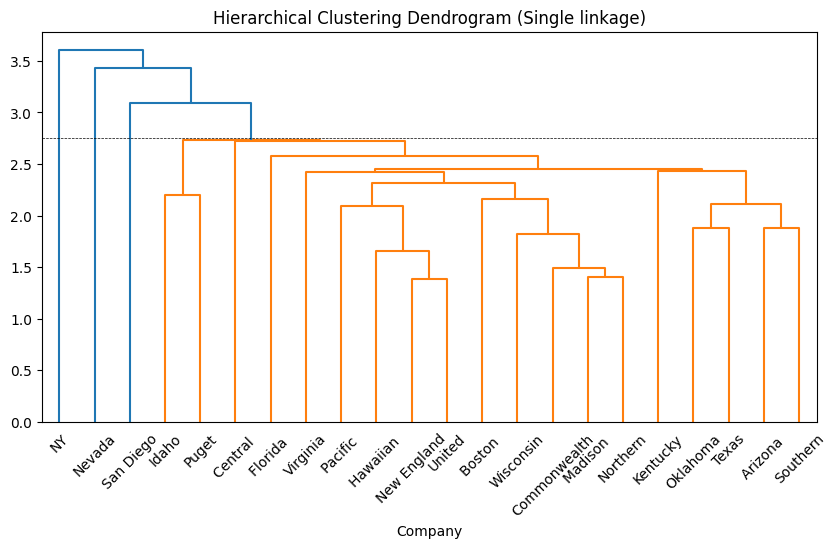

In [ ]:
Z = linkage(utilities_df_norm, method='single') #hierarchical clustering

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=utilities_df_norm.index, color_threshold=2.75)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

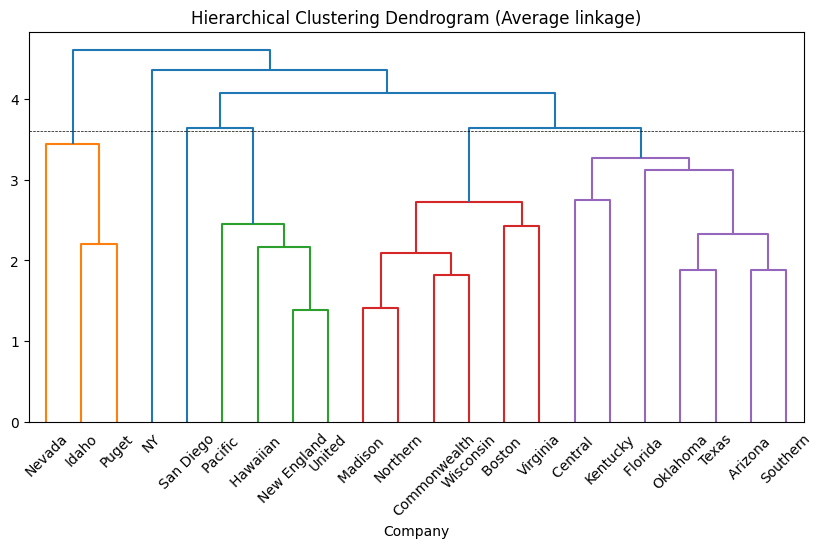

In [ ]:
Z = linkage(utilities_df_norm, method='average')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Average linkage)')
plt.xlabel('Company')
dendrogram(Z, labels=utilities_df_norm.index, color_threshold=3.6)
plt.axhline(y=3.6, color='black', linewidth=0.5, linestyle='dashed')
plt.show()


**K-Means**

In [3]:
# Load and preprocess data
utilities_df = dmba.load_data('Utilities.csv')
utilities_df.set_index('Company', inplace=True)
utilities_df = utilities_df.apply(lambda x: x.astype('float64'))

# Normalized distance
utilities_df_norm = utilities_df.apply(preprocessing.scale, axis=0)

kmeans = KMeans(n_clusters=6, random_state=0).fit(utilities_df_norm) #fit kmeans Note: random state determines random number generation for centroid initialization. Use an int to make the randomness deterministic

# Cluster membership
memb = pd.Series(kmeans.labels_, index=utilities_df_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  Commonwealth, Madison , Northern, Wisconsin, Virginia
1 :  Boston , Hawaiian , New England, Pacific , San Diego, United
2 :  Arizona , Central , Florida , Kentucky, Oklahoma, Southern, Texas
3 :  NY
4 :  Nevada
5 :  Idaho, Puget


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Table 15.10

In [4]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=utilities_df_norm.columns) # create a dataframe with cluster centers as the observations and the columsn of utilities_df_norm as the columns
pd.set_option('display.precision', 3) #set precision shown as 3
print(centroids)
pd.reset_option('display.precision') #reset the precision to its original form

   Fixed_charge    RoR   Cost  Load_factor  Demand_growth  Sales  Nuclear  \
0        -0.012  0.339  0.224       -0.366          0.170 -0.411    1.602   
1        -0.633 -0.640  0.207        1.175          0.058 -0.758   -0.381   
2         0.516  0.798 -1.009       -0.345         -0.501  0.360   -0.536   
3         2.085 -0.883  0.592       -1.325         -0.736 -1.619    0.219   
4        -2.020 -1.476  0.120       -1.257          1.070  2.458   -0.731   
5         0.088 -0.541  1.996       -0.110          0.988  1.621   -0.731   

   Fuel_Cost  
0     -0.609  
1      1.204  
2     -0.420  
3      1.732  
4     -0.616  
5     -1.175  


In [6]:
#create a loop to calculate the within cluster variation
withinClusterSS = [0] * 6
clusterCount = [0] * 6
for cluster, distance in zip(kmeans.labels_, kmeans.transform(utilities_df_norm)):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1
for cluster, withClustSS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster,
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (5 members): 10.66 within cluster
Cluster 1 (6 members): 22.20 within cluster
Cluster 2 (7 members): 27.77 within cluster
Cluster 3 (1 members):  0.00 within cluster
Cluster 4 (1 members):  0.00 within cluster
Cluster 5 (2 members):  2.54 within cluster


## Figure 15.5

,Fixed_charge,RoR,Cost,Load_factor,Demand_growth,Sales,Nuclear,Fuel_Cost,cluster
0,-0.011599,0.339180,0.224086,-0.366466,0.170386,-0.411331,1.601868,-0.609460,Cluster 0
1,-0.632893,-0.639936,0.206692,1.175321,0.057691,-0.757719,-0.380962,1.203616,Cluster 1
2,0.516184,0.797896,-1.009097,-0.345490,-0.501098,0.360140,-0.535523,-0.420198,Cluster 2
3,2.085268,-0.883194,0.591840,-1.325495,-0.735555,-1.618644,0.219434,1.732470,Cluster 3
4,-2.019709,-1.476137,0.119723,-1.256665,1.069762,2.458495,-0.731447,-0.616086,Cluster 4
5,0.088252,-0.541112,1.995766,-0.109502,0.987702,1.621068,-0.731447,-1.174696,Cluster 5


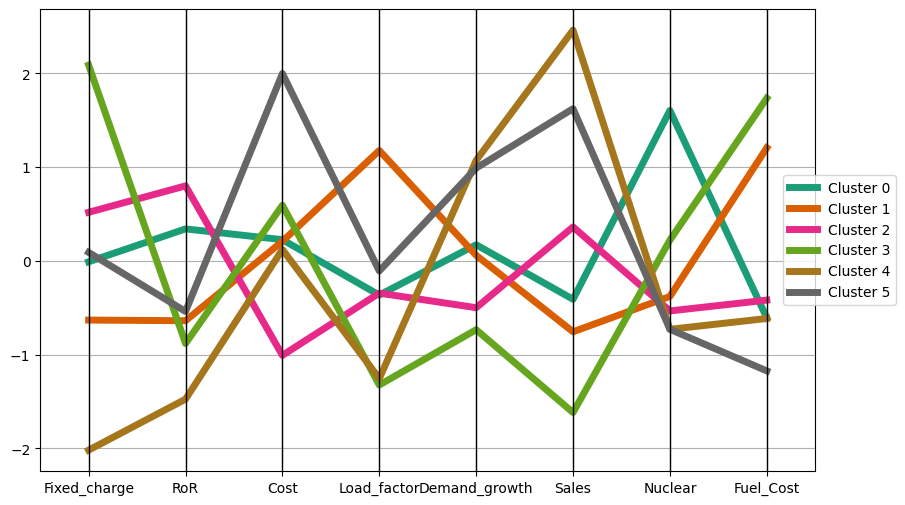

In [ ]:
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]

plt.figure(figsize=(10,6))
fig.subplots_adjust(right=3) #Adjust the subplot layout parameters
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
centroids